# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [2]:
from ema_workbench import (Model, RealParameter, CategoricalParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant, perform_experiments)

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint

import math
import numpy as np
from scipy.optimize import brentq
import pandas as pd

from dps_lake_model import lake_model
from ema_workbench.analysis import parcoords

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_model)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers
lake_model.levers = [RealParameter("c1", -2, 2),
                            RealParameter("c2", -2, 2),
                            RealParameter("r1", 0, 2),
                            RealParameter("r2", 0, 2),
                            RealParameter("w1", 0, 1)]

lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

lake_model.constantcs = [Constant('alpha', 0.41),
                         Constant('reps', 150)],


In [4]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def maxp(data):
    return np.sum(data<=0.75)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)


MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

robustness_functions = [ScalarOutcome('under 0.75 max_p', kind=MINIMIZE,
                             variable_name='max_P', function=maxp),
                       ScalarOutcome('over 0.99 reliability', kind=MAXIMIZE,
                             variable_name='reliability', function=reliability),
                       ScalarOutcome('over 0.6 inertia', kind=MAXIMIZE,
                             variable_name='inertia', function=inertia),
                       ScalarOutcome('over 0.75 utility', kind=MAXIMIZE,
                             variable_name='utility', function=utility)]

**2) Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this. What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

In [5]:
from ema_workbench.em_framework import sample_uncertainties, MonteCarloSampler


In [6]:
n_scenarios = 500
scenarios = sample_uncertainties(lake_model, n_scenarios, MonteCarloSampler)

policy_scenario, results = perform_experiments(lake_model, scenarios=scenarios, policies=4)

policy_scenario

[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished


,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
0,0.176623,0.966922,0.023674,3.817651,0.001162,0.809733,-1.720137,1.770006,1.779183,0.489224,0,0,lakeproblem
1,0.370388,0.972226,0.045108,3.810620,0.002555,0.809733,-1.720137,1.770006,1.779183,0.489224,1,0,lakeproblem
2,0.338810,0.950339,0.024145,2.275163,0.004226,0.809733,-1.720137,1.770006,1.779183,0.489224,2,0,lakeproblem
3,0.190623,0.985169,0.017882,4.309482,0.004379,0.809733,-1.720137,1.770006,1.779183,0.489224,3,0,lakeproblem
4,0.268778,0.977610,0.030816,2.547741,0.002841,0.809733,-1.720137,1.770006,1.779183,0.489224,4,0,lakeproblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.249170,0.989047,0.023174,3.002501,0.001392,1.602395,1.817020,1.486922,0.664495,0.509086,495,3,lakeproblem
1996,0.222493,0.984759,0.025925,3.180887,0.002754,1.602395,1.817020,1.486922,0.664495,0.509086,496,3,lakeproblem
1997,0.131960,0.951512,0.020532,2.432329,0.004289,1.602395,1.817020,1.486922,0.664495,0.509086,497,3,lakeproblem
1998,0.124821,0.981976,0.022601,2.453054,0.004387,1.602395,1.817020,1.486922,0.664495,0.509086,498,3,lakeproblem


In [7]:
results


{'max_P': array([6.35736766, 3.05464881, 3.11199109, ..., 8.44927025, 8.95766155,
        2.75513982]),
 'utility': array([1.16740141, 1.3540566 , 0.80051515, ..., 0.79668459, 1.83006163,
        1.01678822]),
 'inertia': array([0.99  , 0.99  , 0.99  , ..., 0.977 , 0.98  , 0.9728]),
 'reliability': array([0.06  , 0.1628, 0.0594, ..., 0.0299, 0.0286, 0.0528])}

In [8]:
robustness_policy0 = maxp(results['max_P'][0:499]), reliability(results['reliability'][0:499]), utility(results['utility'][0:499]), inertia(results['inertia'][0:499])

robustness_policy1 = maxp(results['max_P'][500:999]), reliability(results['reliability'][500:999]), utility(results['utility'][500:999]), inertia(results['inertia'][500:999])

robustness_policy2 = maxp(results['max_P'][1000:1499]), reliability(results['reliability'][1000:1499]), utility(results['utility'][1000:1499]), inertia(results['inertia'][1000:1499])

robustness_policy3 = maxp(results['max_P'][1500:1999]), reliability(results['reliability'][1500:1999]), utility(results['utility'][1500:1999]), inertia(results['inertia'][1500:1999])


robustness_policy0, robustness_policy1, robustness_policy2, robustness_policy3


((0.09018036072144289, 0.09018036072144289, 0.717434869739479, 1.0),
 (0.14428857715430862, 0.14428857715430862, 0.7134268537074149, 1.0),
 (0.09018036072144289, 0.09018036072144289, 0.717434869739479, 1.0),
 (0.09018036072144289, 0.09018036072144289, 0.685370741482966, 1.0))

## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


In [9]:
#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

n_scenarios = 50
scenarios = sample_uncertainties(lake_model, n_scenarios, MonteCarloSampler)

In [11]:
import time

t0 = time.time()

nfe = int(2000)
with MultiprocessingEvaluator(lake_model) as evaluator:
    robust_results, convergence = evaluator.robust_optimize(robustness_functions, scenarios,
                                    nfe=nfe, convergence_freq=20, epsilons=[0.05,]*len(robustness_functions),                                               population_size=10,convergence=convergence_metrics)

t1 = time.time()

total = t1-t0

total


[MainProcess/INFO] generation 0: 0/2000 nfe
[MainProcess/INFO] generation 5: 49/2000 nfe
[MainProcess/INFO] generation 10: 99/2000 nfe
[MainProcess/INFO] generation 15: 149/2000 nfe
[MainProcess/INFO] generation 20: 199/2000 nfe
[MainProcess/INFO] generation 25: 248/2000 nfe
[MainProcess/INFO] generation 30: 297/2000 nfe
[MainProcess/INFO] generation 35: 347/2000 nfe
[MainProcess/INFO] generation 40: 397/2000 nfe
[MainProcess/INFO] generation 45: 447/2000 nfe
[MainProcess/INFO] generation 50: 496/2000 nfe
[MainProcess/INFO] generation 55: 545/2000 nfe
[MainProcess/INFO] generation 60: 595/2000 nfe
[MainProcess/INFO] generation 65: 645/2000 nfe
[MainProcess/INFO] generation 70: 695/2000 nfe
[MainProcess/INFO] generation 75: 745/2000 nfe
[MainProcess/INFO] generation 80: 794/2000 nfe
[MainProcess/INFO] generation 85: 844/2000 nfe
[MainProcess/INFO] generation 90: 894/2000 nfe
[MainProcess/INFO] generation 95: 943/2000 nfe
[MainProcess/INFO] generation 100: 992/2000 nfe
[MainProcess/INFO]

1867.3276221752167

In [12]:
robust_results

,c1,c2,r1,r2,w1,under 0.75 max_p,over 0.99 reliability,over 0.6 inertia,over 0.75 utility
0,0.811362,-0.351563,0.780205,1.816046,0.261544,0.08,0.08,1.0,0.72
1,0.599263,-0.552726,0.653859,1.858582,0.685139,0.32,0.32,1.0,0.60
2,0.815679,-0.065175,0.775556,1.506545,0.290191,0.26,0.26,1.0,0.60
3,0.639531,-0.568447,0.577464,1.773263,0.802712,0.22,0.22,1.0,0.62
4,0.600126,-0.568447,0.580567,1.773263,0.802712,0.36,0.36,1.0,0.56
5,0.602683,-0.322478,0.563204,1.627331,0.823830,0.42,0.42,1.0,0.54
6,0.455077,0.391592,0.282637,1.530689,0.775005,0.66,0.66,1.0,0.32
7,0.513388,0.390939,0.325941,1.518003,0.859861,0.58,0.58,1.0,0.38
8,0.452013,1.239527,0.191791,1.881790,0.696595,0.46,0.46,1.0,0.50
9,0.507043,-1.001343,0.325941,1.816257,0.859921,0.12,0.12,1.0,0.68


In [13]:
convergence

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.049589,1,10
2,0.066346,2,30
3,0.134086,7,59
4,0.146446,14,79
...,...,...,...
56,0.177952,64,1670
57,0.178102,65,1739
58,0.178102,65,1809
59,0.177414,66,1877


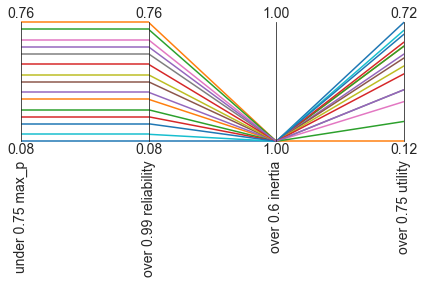

In [14]:
outcomes = robust_results.loc[:, ['under 0.75 max_p', 'over 0.99 reliability', 'over 0.6 inertia', 'over 0.75 utility']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
#axes.invert_axis('max_P') 
#plt.show()

**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

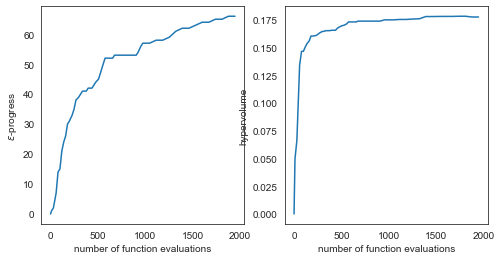

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

In [16]:
from ema_workbench.em_framework.parameters import Policy, Category

In [17]:
robust_result_subsection = robust_results.iloc[:,:5].to_dict("records")

#add policies
robust_policies = []

for number in range(14):
    robust_policies.append(Policy("Policy"+str(number), **robust_result_subsection[number]) )

robust_policies

[Policy({'c1': 0.811361504805485, 'c2': -0.3515633598453481, 'r1': 0.7802054326023776, 'r2': 1.81604571740475, 'w1': 0.26154388943746953}),
 Policy({'c1': 0.5992626249999522, 'c2': -0.5527259430395319, 'r1': 0.6538586113454636, 'r2': 1.8585815333281208, 'w1': 0.6851392653010834}),
 Policy({'c1': 0.8156786809696401, 'c2': -0.06517539874334305, 'r1': 0.7755555281955984, 'r2': 1.5065453012784382, 'w1': 0.29019088048072855}),
 Policy({'c1': 0.639530666891631, 'c2': -0.5684466494434766, 'r1': 0.5774637941476488, 'r2': 1.7732632411077212, 'w1': 0.802712290789354}),
 Policy({'c1': 0.6001257657238277, 'c2': -0.5684466494434766, 'r1': 0.5805669913061313, 'r2': 1.7732632411077212, 'w1': 0.802712290789354}),
 Policy({'c1': 0.6026826278187982, 'c2': -0.3224784500310879, 'r1': 0.5632040745811944, 'r2': 1.627330928902971, 'w1': 0.8238302440696782}),
 Policy({'c1': 0.4550765075734487, 'c2': 0.3915919088704515, 'r1': 0.28263696682791817, 'r2': 1.5306890877870043, 'w1': 0.7750049632350948}),
 Policy({'

In [18]:
n_scenarios = 500
scenarios = sample_uncertainties(lake_model, n_scenarios, MonteCarloSampler)

with MultiprocessingEvaluator(lake_model) as evaluator:
    policy_comparison, results_comparison = perform_experiments(lake_model, scenarios=scenarios, policies=robust_policies)


In [19]:
policy_comparison

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
0,0.182183,0.953304,0.032625,2.445171,0.004940,0.811362,-0.351563,0.780205,1.816046,0.261544,6800,Policy0,lakeproblem
1,0.285501,0.941191,0.046451,2.672598,0.002601,0.811362,-0.351563,0.780205,1.816046,0.261544,6801,Policy0,lakeproblem
2,0.149895,0.985190,0.015474,3.152000,0.003536,0.811362,-0.351563,0.780205,1.816046,0.261544,6802,Policy0,lakeproblem
3,0.134700,0.939359,0.037061,3.338454,0.004743,0.811362,-0.351563,0.780205,1.816046,0.261544,6803,Policy0,lakeproblem
4,0.396957,0.971880,0.033000,4.042580,0.003980,0.811362,-0.351563,0.780205,1.816046,0.261544,6804,Policy0,lakeproblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.424092,0.945642,0.039276,2.212155,0.001701,0.874868,0.514680,1.938498,0.197668,0.525259,7295,Policy13,lakeproblem
6996,0.429930,0.984441,0.025623,2.351246,0.001440,0.874868,0.514680,1.938498,0.197668,0.525259,7296,Policy13,lakeproblem
6997,0.244892,0.961963,0.038334,2.759512,0.004345,0.874868,0.514680,1.938498,0.197668,0.525259,7297,Policy13,lakeproblem
6998,0.112711,0.950274,0.028349,3.501484,0.001627,0.874868,0.514680,1.938498,0.197668,0.525259,7298,Policy13,lakeproblem


In [20]:
results_comparison


{'max_P': array([ 6.15523381,  3.92766179,  7.42982897, ...,  4.58943136,
        10.0084948 ,  0.40286042]),
 'utility': array([0.84545026, 0.67417935, 2.08727949, ..., 0.94540499, 0.72528212,
        1.0312788 ]),
 'inertia': array([0.99  , 0.99  , 0.99  , ..., 0.9774, 0.9781, 0.9128]),
 'reliability': array([0.03, 0.05, 0.05, ..., 0.05, 0.04, 1.  ])}

In [26]:
robustness_policy0 = maxp(results_comparison['max_P'][0:499]), reliability(results_comparison['reliability'][0:499]), inertia(results_comparison['inertia'][0:499]), utility(results_comparison['utility'][0:499])

robustness_policy1 = maxp(results_comparison['max_P'][500:999]), reliability(results_comparison['reliability'][500:999]), inertia(results_comparison['inertia'][500:999]), utility(results_comparison['utility'][500:999])

robustness_policy2 = maxp(results_comparison['max_P'][1000:1499]), reliability(results_comparison['reliability'][1000:1499]), inertia(results_comparison['inertia'][1000:1499]), utility(results_comparison['utility'][1000:1499])

robustness_policy3 = maxp(results_comparison['max_P'][1500:1999]), reliability(results_comparison['reliability'][1500:1999]), inertia(results_comparison['inertia'][1500:1999]), utility(results_comparison['utility'][1500:1999])

robustness_policy4 = maxp(results_comparison['max_P'][2000:2499]), reliability(results_comparison['reliability'][2000:2499]), inertia(results_comparison['inertia'][2000:2499]), utility(results_comparison['utility'][2000:2499])

robustness_policy5 = maxp(results_comparison['max_P'][2500:2999]), reliability(results_comparison['reliability'][2500:2999]), inertia(results_comparison['inertia'][2500:2999]), utility(results_comparison['utility'][2500:2999])

robustness_policy6 = maxp(results_comparison['max_P'][3000:3499]), reliability(results_comparison['reliability'][3000:3499]), inertia(results_comparison['inertia'][3000:3499]), utility(results_comparison['utility'][3000:3499])

robustness_policy7 = maxp(results_comparison['max_P'][3500:3999]), reliability(results_comparison['reliability'][3500:3999]), inertia(results_comparison['inertia'][3500:3999]), utility(results_comparison['utility'][3500:3999])

robustness_policy8 = maxp(results_comparison['max_P'][4000:4499]), reliability(results_comparison['reliability'][4000:4499]), inertia(results_comparison['inertia'][4000:4499]), utility(results_comparison['utility'][4000:4499])

robustness_policy9 = maxp(results_comparison['max_P'][4500:4999]), reliability(results_comparison['reliability'][4500:4999]), inertia(results_comparison['inertia'][4500:4999]), utility(results_comparison['utility'][4500:4999])

robustness_policy10 = maxp(results_comparison['max_P'][5000:5499]), reliability(results_comparison['reliability'][5000:5499]), inertia(results_comparison['inertia'][5000:5499]), utility(results_comparison['utility'][5000:5499])

robustness_policy11 = maxp(results_comparison['max_P'][5500:5999]), reliability(results_comparison['reliability'][5500:5999]), inertia(results_comparison['inertia'][5500:5999]), utility(results_comparison['utility'][5500:5999])

robustness_policy12 = maxp(results_comparison['max_P'][6000:6499]), reliability(results_comparison['reliability'][6000:6499]), inertia(results_comparison['inertia'][6000:6499]), utility(results_comparison['utility'][6000:6499])

robustness_policy13 = maxp(results_comparison['max_P'][6500:6999]), reliability(results_comparison['reliability'][6500:6999]), inertia(results_comparison['inertia'][6500:6999]), utility(results_comparison['utility'][6500:6999])

In [27]:
robustness_policy1, robustness_policy2, robustness_policy3, robustness_policy4, robustness_policy5, robustness_policy6, robustness_policy7, robustness_policy8, robustness_policy9, robustness_policy10, robustness_policy11, robustness_policy12, robustness_policy13

((0.2625250501002004, 0.2625250501002004, 1.0, 0.6292585170340681),
 (0.250501002004008, 0.250501002004008, 1.0, 0.6332665330661322),
 (0.23647294589178355, 0.23647294589178355, 1.0, 0.6472945891783567),
 (0.2905811623246493, 0.28857715430861725, 1.0, 0.6092184368737475),
 (0.38276553106212424, 0.38276553106212424, 1.0, 0.5551102204408818),
 (0.5991983967935872, 0.5971943887775552, 1.0, 0.41282565130260523),
 (0.5370741482965932, 0.533066132264529, 1.0, 0.4589178356713427),
 (0.46292585170340683,
  0.46092184368737477,
  0.9839679358717435,
  0.5250501002004008),
 (0.16633266533066132, 0.16633266533066132, 1.0, 0.6953907815631263),
 (0.22444889779559118, 0.22444889779559118, 1.0, 0.6693386773547094),
 (0.6713426853707415, 0.6673346693386774, 1.0, 0.21042084168336672),
 (0.6533066132264529, 0.6533066132264529, 1.0, 0.280561122244489),
 (0.501002004008016,
  0.49899799599198397,
  0.9859719438877755,
  0.48096192384769537))

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?